<a href="https://colab.research.google.com/github/arnabbiswas66/multimodal-fake-news-classifier/blob/main/Twitter_multimodal_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from tensorflow.python.platform.tf_logging import warn
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import re
from os import listdir
import shutil
import glob
import random
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')
import warnings

warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
BASE_SAVE_LOCATION = "/content/drive/MyDrive/multimodal-news"

In [5]:
def load_files(file):
    return pd.read_table(file,sep = '\t', lineterminator='\n')

In [6]:
train_df = load_files('/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/tweets.txt')
test_df = load_files('/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/tweets.txt')

In [7]:

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14277 non-null  int64 
 1   tweetText   14277 non-null  object
 2   userId      14277 non-null  int64 
 3   imageId(s)  14277 non-null  object
 4   username    14277 non-null  object
 5   timestamp   14277 non-null  object
 6   label       14277 non-null  object
dtypes: int64(2), object(5)
memory usage: 780.9+ KB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     3755 non-null   int64 
 1   tweetText   3755 non-null   object
 2   userId      3755 non-null   int64 
 3   imageId(s)  3755 non-null   object
 4   username    3755 non-null   object
 5   timestamp   3755 non-null   object
 6   label       3755 non-null   object
dtypes: int64(2), object(5)
memory usage: 205.5+ KB


## Flatten the image folder structure for both devset and testset for ease of processing

In [ ]:
def flatten(directory, targetDir):
    if not os.path.exists(targetDir):
        os.makedirs(targetDir)
    for dirpath, _, filenames in os.walk(directory, topdown=False):
        for filename in filenames:
            i = 0
            source = os.path.join(dirpath, filename)
            target = os.path.join(targetDir, filename)

            shutil.move(source, target)

    print("Moved", directory, "to", targetDir)

In [ ]:
# Devset
SRC_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/Medieval2015_DevSet_Images/'
TARGET_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/images/'

flatten(SRC_DIR, TARGET_DIR)

Moved /content/drive/MyDrive/multimodal-news/mediaeval2015/devset/Medieval2015_DevSet_Images/ to /content/drive/MyDrive/multimodal-news/mediaeval2015/devset/images/


In [ ]:
# Testset
SRC_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/TestSetImages/'
TARGET_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/images/'

flatten(SRC_DIR, TARGET_DIR)

Moved /content/drive/MyDrive/multimodal-news/mediaeval2015/testset/TestSetImages/ to /content/drive/MyDrive/multimodal-news/mediaeval2015/testset/images/


## Initial Preprocessing of data

In [9]:
# TODO consider both the images and not just the first one
def return_first_image(row):
    return row['imageId(s)'].split(',')[0].strip()

In [10]:
train_df['first_image_id'] = train_df.apply (lambda row: return_first_image(row),axis=1)
test_df['first_image_id'] = test_df.apply (lambda row: return_first_image(row),axis=1)

In [11]:
images_train_dataset = [i for i in train_df['first_image_id'].tolist()]
images_train_folder = [i.split('.')[0].strip() for i in listdir('/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/images/')]
images_train_not_available = set(images_train_dataset)-set(images_train_folder)
images_train_not_available

{'boston_fake_35', 'sandyB_real_4', 'sandyB_real_6', 'sochi_fake_1fake'}

In [12]:
images_test_dataset = [i.split(',')[0].strip() for i in test_df['first_image_id'].tolist()]
images_test_folder = [i.split('.')[0].strip() for i in listdir('/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/images/')]
images_test_not_available = set(images_test_dataset)-set(images_test_folder)
images_test_not_available

{'eclipse_video_01', 'syrianboy_1', 'varoufakis_1'}

In [13]:
print(train_df.shape, test_df.shape)

(14277, 8) (3755, 8)


In [14]:
train_df = train_df[~train_df['first_image_id'].isin(images_train_not_available)]

In [15]:
test_df = test_df[~test_df['first_image_id'].isin(images_test_not_available)]
print(train_df.shape, test_df.shape)

(14258, 8) (1923, 8)


In [16]:
train_text = train_df['tweetText'].tolist()
test_text = test_df['tweetText'].tolist()

train_images = [i for i in train_df['first_image_id'].tolist()]
test_images = [i.split(',')[0].strip() for i in test_df['first_image_id'].tolist()]

trainY = train_df['label'].tolist()
trainY = [1 if i=='real' else 0 for i in trainY]

testY = test_df['label'].tolist()
testY = [1 if i=='real' else 0 for i in testY]

In [17]:
len(train_text),len(train_images),len(trainY),len(test_text),len(test_images),len(testY)

(14258, 14258, 14258, 1923, 1923, 1923)

In [18]:
# calculate the maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])

maximum length: 901


(array([   0.,    4.,  327.,  532.,  755.,  760.,  843.,  791.,  904.,
        2534., 2379.,  775., 1462., 1113., 1047.,   17.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 12., 15., 16.,
        18., 20., 25., 30.]),
 <BarContainer object of 16 artists>)

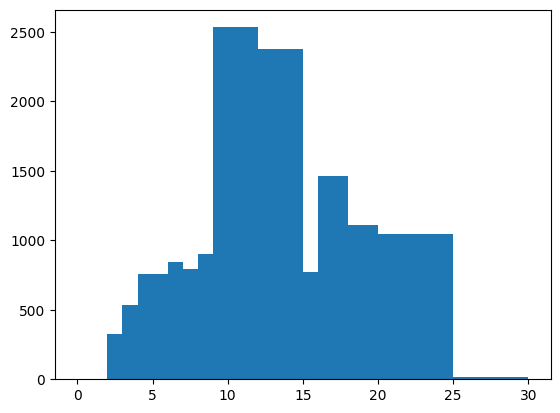

In [19]:
print("maximum length:", max_length(train_text))
plt.hist([len(s.split()) for s in train_text],bins=[0,1,2,3,4,5,6,7,8,9,12,15,16,18,20,25,30])

In [20]:
l=[len(s.split()) for s in train_text]
count=0.0
for i in l:
    if i>25:
        count+=1
print(count,len(l))
print(count/len(l))

17.0 14258
0.0011923130873895357


In [21]:
max_seq_length=25

# Visualize random tweets

In [22]:
DEV_IMAGE_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/images/'
TEST_IMAGE_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/images/'

In [23]:
def find_image_from_name_in_dir(image_name, dir):
  for name in glob.glob(dir+'/'+image_name+'.*'):
    return name

In [24]:
def visualise(index, text_df, image_df, train=True):
  path = DEV_IMAGE_DIR if train else TEST_IMAGE_DIR
  text = text_df[index]
  image_path = find_image_from_name_in_dir(image_df[index],path)
  image = plt.imread(image_path)
  plt.subplot(1, 1, 1)
  plt.title(text)
  plt.imshow(image)


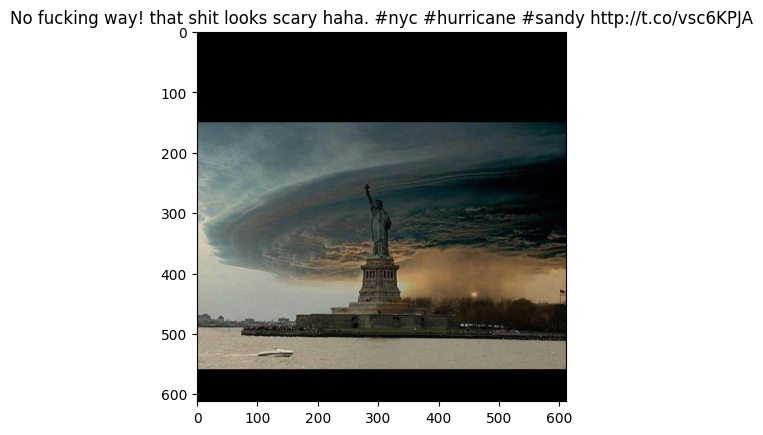

In [25]:
indx = random.randint(0, 3000)
visualise(indx, train_text, train_images)

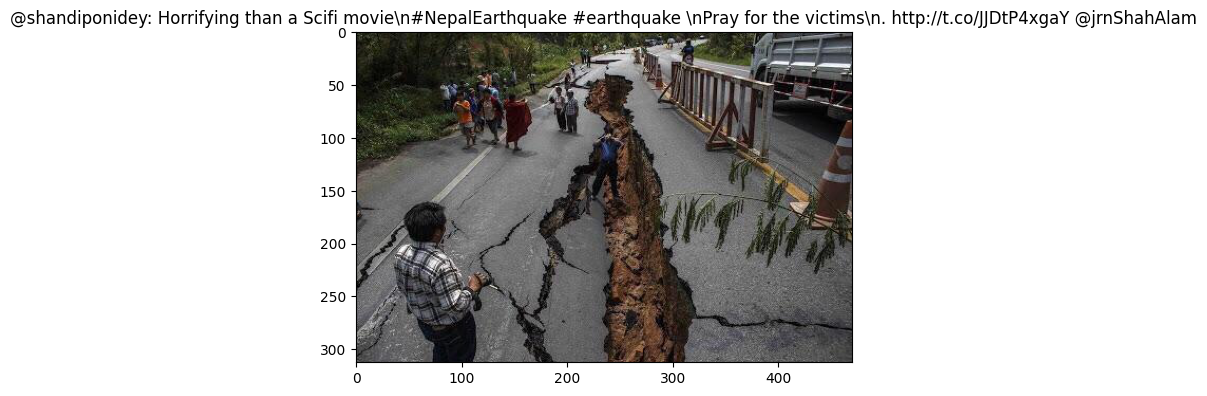

In [26]:
indx = random.randint(0, 1000)
visualise(indx, test_text, test_images, False)

## Create dataframes for modeling

In [27]:
# Alternate dataframes for modeling
train_df_model = train_df[['tweetText', 'first_image_id', 'label']]
train_df_model['label'] = train_df_model['label'].apply(lambda x: 1 if x=='real' else 0)
train_df_model['image_1'] = train_df_model['first_image_id'].apply(lambda x: find_image_from_name_in_dir(x, DEV_IMAGE_DIR))
train_df_model = train_df_model.drop(['first_image_id'], axis=1)
train_df_model.head(5)

,tweetText,label,image_1
0,¿Se acuerdan de la película: “El día después d...,0,/content/drive/MyDrive/multimodal-news/mediaev...
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,0,/content/drive/MyDrive/multimodal-news/mediaev...
2,"Buena la foto del Huracán Sandy, me recuerda a...",0,/content/drive/MyDrive/multimodal-news/mediaev...
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,0,/content/drive/MyDrive/multimodal-news/mediaev...
4,My fave place in the world #nyc #hurricane #sa...,0,/content/drive/MyDrive/multimodal-news/mediaev...


In [28]:
# Check to make sure all the first_image_id are tied with a path
train_df_model[train_df_model['image_1'].isnull()]

,tweetText,label,image_1


In [29]:
train_df_model['label'].value_counts()

0    9353
1    4905
Name: label, dtype: int64

In [30]:
test_df_model = test_df[['tweetText', 'first_image_id', 'label']]
test_df_model['label'] = test_df_model['label'].apply(lambda x: 1 if x=='real' else 0)
test_df_model['image_1'] = test_df_model['first_image_id'].apply(lambda x: find_image_from_name_in_dir(x, TEST_IMAGE_DIR))
test_df_model = test_df_model.drop(['first_image_id'], axis=1)
test_df_model.head(10)

,tweetText,label,image_1
0,kereeen RT @Shyman33: Eclipse from ISS.... htt...,0,/content/drive/MyDrive/multimodal-news/mediaev...
1,Absolutely beautiful! RT @Shyman33: Eclipse fr...,0,/content/drive/MyDrive/multimodal-news/mediaev...
2,“@Shyman33: Eclipse from ISS.... http://t.co/C...,0,/content/drive/MyDrive/multimodal-news/mediaev...
3,Eclipse from ISS.... http://t.co/En87OtvsU6,0,/content/drive/MyDrive/multimodal-news/mediaev...
4,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,0,/content/drive/MyDrive/multimodal-news/mediaev...
5,“@ebonfigli: Éclipse vue de l'ISS... Autre cho...,0,/content/drive/MyDrive/multimodal-news/mediaev...
6,Éclipse vue de l'ISS... Autre chose... http://...,0,/content/drive/MyDrive/multimodal-news/mediaev...
7,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,0,/content/drive/MyDrive/multimodal-news/mediaev...
8,Dit dus \0/ RT “@News_Executive: The Solar ecl...,0,/content/drive/MyDrive/multimodal-news/mediaev...
9,Photo: The Solar eclipse as seen from the Inte...,0,/content/drive/MyDrive/multimodal-news/mediaev...


In [31]:
# Check to make sure all the first_image_id are tied with a path
test_df_model[test_df_model['image_1'].isnull()]

,tweetText,label,image_1


In [32]:
test_df_model['label'].value_counts()

1    1207
0     716
Name: label, dtype: int64

### Save the dataframes for faster access

In [33]:
#Save training df
train_df_model.to_pickle(BASE_SAVE_LOCATION+"/twitter-train.pickle")
#Save testing df
test_df_model.to_pickle(BASE_SAVE_LOCATION+"/twitter-test.pickle")